In [1]:
import pandas as pd
import numpy as np
import math

import plotly.express as px
from plotly.subplots import make_subplots

# Data Load

In [2]:
from keras.datasets import mnist

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)

(60000, 28, 28)


# Sample Visualization

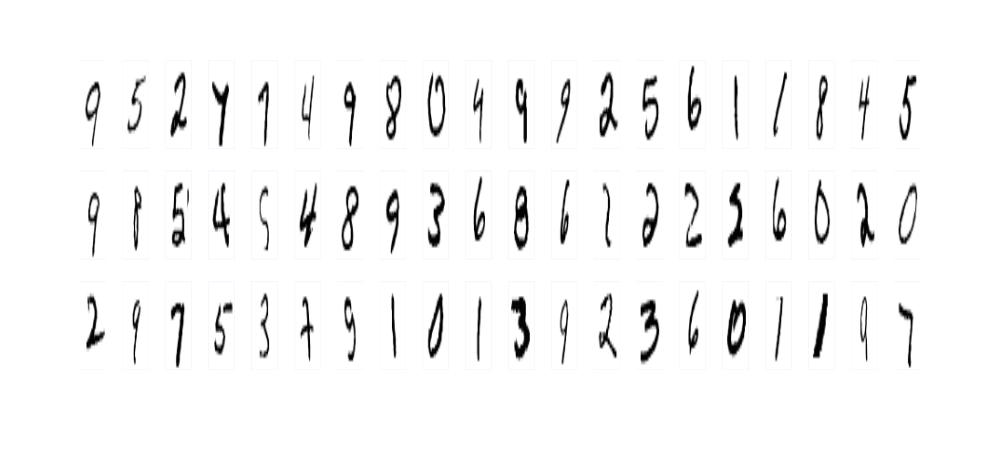

In [7]:
samples = 60
idx = np.random.choice(x_train.shape[0], samples)
arr = x_train[idx]

fig = px.imshow(
    arr,
    zmin=0,
    zmax=255,
    color_continuous_scale='greys',
    facet_col=0,
    aspect='auto',
    facet_col_wrap=20,
    facet_row_spacing=0,
    facet_col_spacing=0,
)
fig.update_coloraxes(showscale=False)
fig.update_layout(height=450, width=1000)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.for_each_annotation(lambda a: a.update(text=""))
fig.show('svg')

# data sampling & normalization

In [9]:
samples = 5000
idx = np.random.choice(x_train.shape[0], samples)
X = x_train[idx]
Y = y_train[idx]

# normalization
X_norm = X/255

# tsne

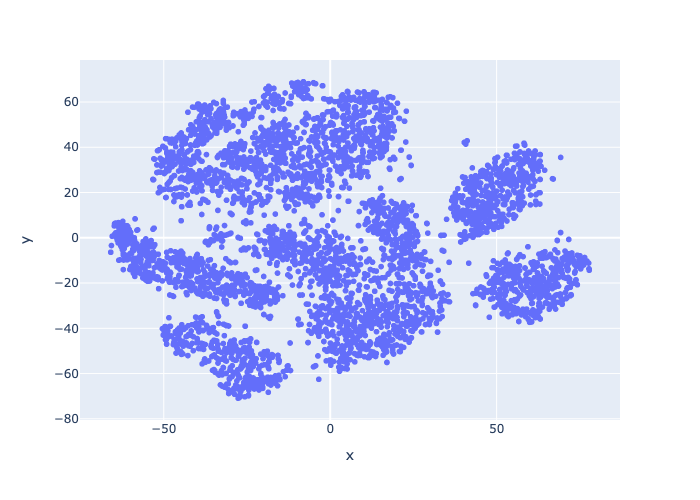

In [73]:
from sklearn.manifold import TSNE

X_flat = X_norm.reshape(len(X_norm), -1)
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_flat)
df_tsne = pd.DataFrame(X_embedded, columns=['x','y'])

fig = px.scatter(df_tsne, x='x', y='y')
fig.update_layout(height=500)
fig.show('png')

# k-means clustering

In [75]:
from sklearn.cluster import KMeans

# Define the number of clusters you want to create
num_clusters = 20

# Create a KMeans clustering model
kmeans = KMeans(n_clusters=num_clusters)

# Fit the model to the data
kmeans.fit(X_flat)

# Get the cluster labels for each data point
cluster_labels = kmeans.labels_

# Get the coordinates of the cluster centers
cluster_centers = kmeans.cluster_centers_

/Users/lydiachew_1/coding/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



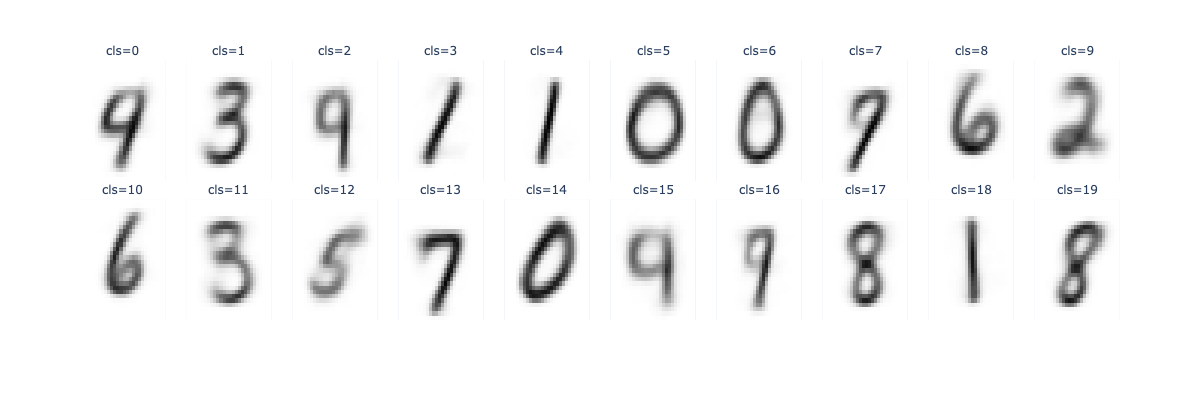

In [76]:
arr = cluster_centers.reshape(-1, 28, 28)
fig = px.imshow(
    arr,
    color_continuous_scale='greys',
    facet_col=0,
    aspect='auto',
    facet_col_wrap=10,
    facet_row_spacing=0,
    facet_col_spacing=0,
)
fig.update_layout(height=math.ceil(arr.shape[0]/10)*200, width=1200)
fig.update_coloraxes(showscale=False)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
for a in fig.layout.annotations:
    x = a.text
    a.text = f'cls={x[10-len(x):]}'
fig.show('png')

# tsne + k-means cluster visualization

In [18]:
df = df_tsne.copy()
df['cls'] = cluster_labels

sort_order = [str(i) for i in sorted(df['cls'].unique())]

df['cls'] = df['cls'].astype('str')
df['idx'] = df.index

df = df.join(pd.DataFrame(X_flat))
df['actual'] = Y
df['actual'] = df['actual'].astype('str')

display(df.head())

,x,y,cls,idx,0,1,2,3,4,5,...,775,776,777,778,779,780,781,782,783,actual
0,-31.942871,28.587536,4,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
1,-61.919891,-7.625466,11,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,-43.675644,-9.321247,8,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,52.009373,14.707940,14,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
4,9.562707,-36.525894,3,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


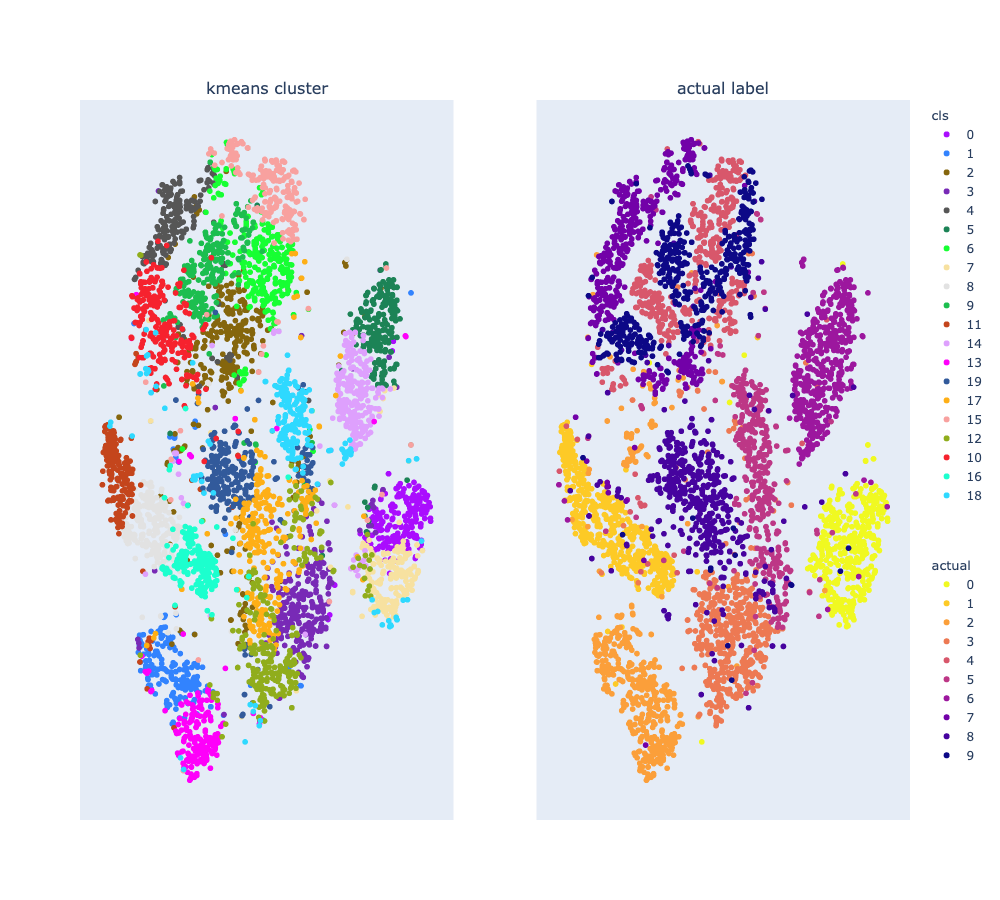

In [77]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['kmeans cluster', 'actual label'])

# plot by k-means cluster, cls
fig_kmeans = px.scatter(
    df, x='x', y='y',
    color='cls',
    category_orders={'cls': sort_order},
    hover_name='idx',
    color_discrete_sequence=px.colors.qualitative.Alphabet,
    width=600,
)
fig_kmeans.update_layout(title='TSNE by k-means cluster', height=600)

# plot by actual label
sort_order = [str(i) for i in sorted(df['actual'].unique())]
fig_label = px.scatter(
    df, x='x', y='y',
    color='actual',
    category_orders={'actual': sort_order},
    hover_name='idx',
    color_discrete_sequence=px.colors.sequential.Plasma_r,
    width=600,
)
fig_label.update_layout(title='TSNE by actual label', height=600)

# combine plots
for data in fig_kmeans.data:
    fig.add_trace(data, row=1, col=1)

for data in fig_label.data:
    fig.add_trace(data, row=1, col=2)

fig.update_traces(legendgroup='cls', legendgrouptitle_text='cls', row=1, col=1)
fig.update_traces(legendgroup='actual', legendgrouptitle_text='actual', row=1, col=2)

fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)

fig.update_layout(
    height=900,
    width=1000,
    legend = dict(
        tracegroupgap=50,
    )
)
fig.show('png')

# Dash visualization

In [70]:
import dash
from dash import html, dcc
from dash.dependencies import Input, Output, State
import math

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)
img_cols = 10
img_base = 0
img_res = (28, 28) # (x,y)
feat_col = list(range(0,784))


app.layout = html.Div([
    html.H2(children='TSNE Plot + Image Viewer'),
    html.Div([
        # tsne section
        html.Div([
            html.H4('TSNE'),
            html.Div([
                html.Div([
                    html.Label('Color By'),
                ], style={'padding':10, 'align':'middle'}),
                html.Div([
                    dcc.Dropdown(
                        id='dd_color_by',
                        options=[{'label':'Cluster', 'value':'cls'}, {'label':'Actual', 'value':'actual'}],
                        value='cls',
                        clearable=False,
                        style=dict(width=100),
                    ),
                ])
            ], style={'display': 'flex', 'flex-direction': 'row'}),
            dcc.Graph(id='graph_tsne'),
        ], style={'padding': 10, 'flex': 1}),
        # image section
        html.Div([
            html.H4('Images'),
            html.Div([
                html.Div([
                    html.Label('No. of Images')
                ], style={'padding':10, 'align':'middle'}),
                html.Div([
                    dcc.Dropdown(
                        id='dd_img_samples',
                        options=[{'label':i, 'value':i} for i in [40, 60, 80, 100]],
                        value=40,
                        clearable=False,
                        style=dict(width=100),
                    ),
                ])
            ], style={'display': 'flex', 'flex-direction': 'row'}),
            dcc.Graph(id='graph_images'),
        ], style={'padding': 10, 'flex': 2}),
    ], style={'display': 'flex', 'flex-direction': 'row'}), 
], id='main_page')

@app.callback(
    Output('graph_tsne', 'figure'),
    Input('dd_color_by', 'value'),
)
def graph_tsne_change(value):
    if value=='cls':
        fig = fig_kmeans
    else:
        fig = fig_label            

    return fig

@app.callback(
    Output('graph_images', 'figure'),
    Input('graph_tsne', 'selectedData'),
    Input('dd_img_samples', 'value'),
)
def graph_interact(selectedData, num_img):
    """ Callback to return figure of images based on selected
        points in from graph_tsne, limited to number of samples
    """
    # create initial figure
    fig = px.imshow(
        [[img_base for x in range(img_res[0])] for y in range(img_res[0])],
        zmin=0, zmax=1,
        color_continuous_scale='greys',
        aspect='auto',
    )
    fig.update_coloraxes(showscale=False)
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.update_layout(
        margin=dict(t=70, l=50, r=0, b=5),
        title=f'No images selected',
        height=200,
        font=dict(size=10)
    )

    if selectedData:
        if len(selectedData['points']) > 0:
            # extract xy from selectedData in graph_tsne
            xy = pd.DataFrame(
                [[i['x'], i['y']] for i in selectedData['points']],
                columns=['x','y']
            ).drop_duplicates()

            # get dataset
            img = df.copy()

            # transform dataset
            img = img.merge(xy)
            tot_img = len(img)
            img = img.head(num_img)
            titles = [f'id={i[0]}<br>[{i[2]}]cls={i[1]}' for i in img[['idx', 'cls','actual']].values]
            arr = img[feat_col].values.reshape(-1, img_res[0], img_res[1])

            numrows = max(1, math.ceil(len(img)/img_cols))

            # create chart
            fig = px.imshow(
                arr,
                zmin=0,
                zmax=1,
                color_continuous_scale='greys',
                facet_col=0,
                aspect='auto',
                facet_col_wrap=img_cols,
                facet_row_spacing=0,
                facet_col_spacing=0,
            )
            fig.update_coloraxes(showscale=False)
            fig.update_xaxes(visible=False)
            fig.update_yaxes(visible=False)
            fig.update_layout(
                margin=dict(t=70, l=50, r=0, b=5),
                title=f'Showing {len(img)} of {tot_img}',
                height=100+numrows*100,
                coloraxis_showscale=False,
                font=dict(size=10)
            )
            for a in fig.layout.annotations:
                x = a.text
                a.text = titles[int(x[10-len(x):])]
        
    return fig 

app.run_server(mode='inline')

In [72]:
# this is for running it on local host port 5000
server = app.server
if __name__ == '__main__':
    app.run_server(host='0.0.0.0', port=5000)